In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

In [2]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [3]:
@dataclass
class SchedulerType(Enum):
    """The type of scheduler to use."""

    BASELINE = auto()
    SIMPLE = auto()
    EXTENDED = auto()  

In [4]:

# Find the type of algorithm
typeAlgorithm = os.listdir('component/d_scheduling/algorithm')
cleantypeAlgorithm = [item for item in typeAlgorithm if item not in ['__pycache__', '__init__.py']]
# make clean typeAlgorithm
dictAlgorithm = {}
for item in cleantypeAlgorithm:
    dictAlgorithm[item] = os.listdir('component/d_scheduling/algorithm/' + item)
    # make clean nameAlgorithm
    cleandictAlgorithm = [item for item in dictAlgorithm[item] if item not in ['__pycache__', '__init__.py']]
    dictAlgorithm[item] = cleandictAlgorithm

print(dictAlgorithm)


{'ilp': ['MILQ_extend', 'MILQ_simple'], 'ai': [], 'heuristic': []}


# We can choose the backend here:
# - get backend from IBMQBacked
# - get backend from Aer provider (not exist yet)
# - visualize the backend errors map
# - have the value about backend errors in the gate (not exist yet)

In [5]:
# Get list backend
from component.a_backend.backend_info import IBMQBackend
backend_list = [member.name for member in IBMQBackend]
print(backend_list)

['BELEM', 'NAIROBI', 'QUITO']


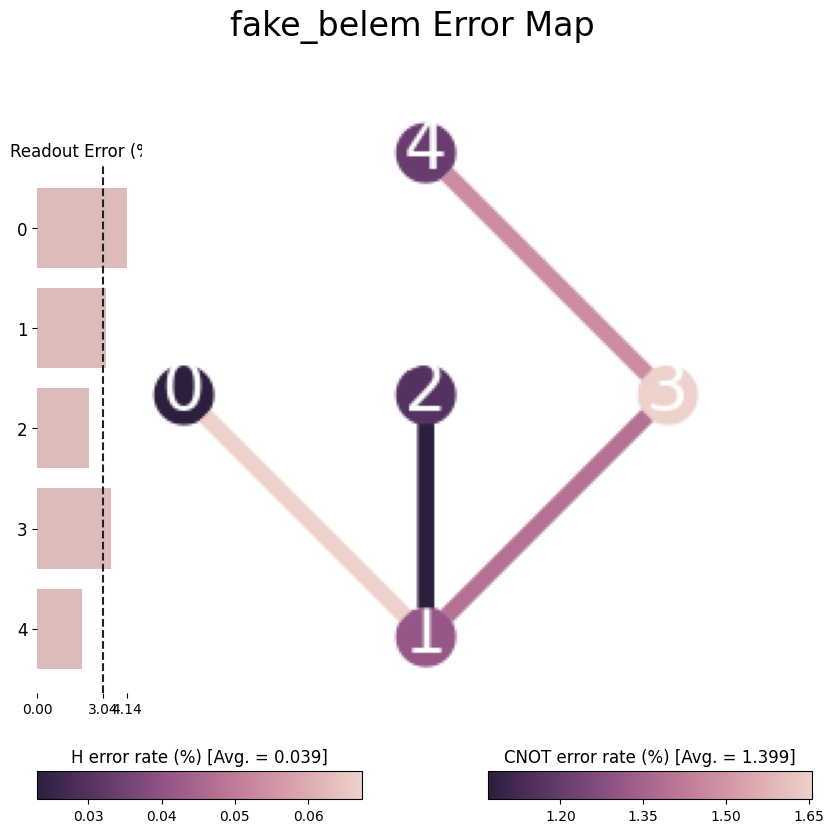

In [7]:
# Draw struct of backend
# using fakebackend or using aer simulator
from qiskit.visualization import plot_error_map
from qiskit_ibm_runtime.fake_provider import FakeBelemV2
plot_error_map(FakeBelemV2(), figsize=(10, 10))

# This is the list benchmark circuits:
# Create the benchmark circuits with the following names:
- **ae**: Amplitude Estimation (AE)
- **dj**: Deutsch-Jozsa
- **grover-noancilla**: Grover’s (no ancilla)
- **grover-v-chain**: Grover’s (v-chain)
- **ghz**: GHZ State
- **graphstate**: Graph State
- **portfolioqaoa**: Portfolio Optimization with QAOA
- **portfoliovqe**: Portfolio Optimization with VQE
- **qaoa**: Quantum Approximation Optimization Algorithm (QAOA)
- **qft**: Quantum Fourier Transformation (QFT)
- **qftentangled**: QFT Entangled
- **qnn**: Quantum Neural Network (QNN)
- **qpeexact**: Quantum Phase Estimation (QPE) exact
- **qpeinexact**: Quantum Phase Estimation (QPE) inexact
- **qwalk-noancilla**: Quantum Walk (no ancilla)
- **qwalk-v-chain**: Quantum Walk (v-chain)
- **random**: Random Quantum Circuit
- **realamprandom**: Real Amplitudes ansatz with Random Parameters
- **su2random**: Efficient SU2 ansatz with Random Parameters
- **twolocalrandom**: Two Local ansatz with Random Parameters
- **vqe**: Variational Quantum Eigensolver (VQE)
- **wstate**: W-State
- **shor**: Shor’s
- **pricingcall**: Pricing Call Option
- **pricingput**: Pricing Put Option
- **groundstate**: Ground State
- **routing**: Routing
- **tsp**: Travelling Salesman

# Visualize the benchmark circuits
# Print the information about the benchmark circuits (not exist yet)


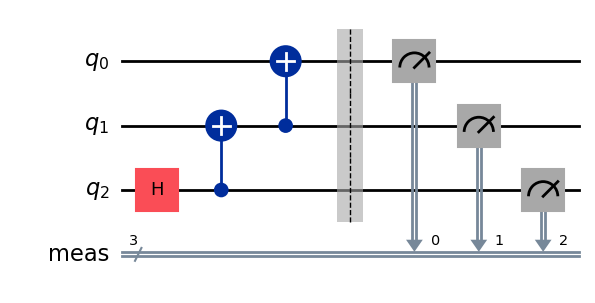

In [9]:
# create benchmark

from component.b_benchmark.mqt_tool import benchmark_circuit

circuitTest = benchmark_circuit("ghz", 3)
circuitTest.draw("mpl")

# Apply circuit cutting/knitting to the benchmark circuits as require ment
# If the benchmark circuit is too large, we can apply circuit cutting/knitting to the benchmark circuits
# We have cutting to solving the width and the depth of the circuit
## For the width, we can use the following methods:
### Cutting gates:
### Cutting wires:
## For the depth, we can use the following methods:
### Cutting gates:
### Cutting wires:

# If the benchmark circuit is too small, we can apply circuit knitting to the benchmark circuits
# We have knitting to solving the width and the depth of the circuit
## For the depth, we can use the following methods:
### Knitting gates:
### Knitting wires:
## For the width, we can use the following methods:
### Knitting gates:
### Knitting wires:


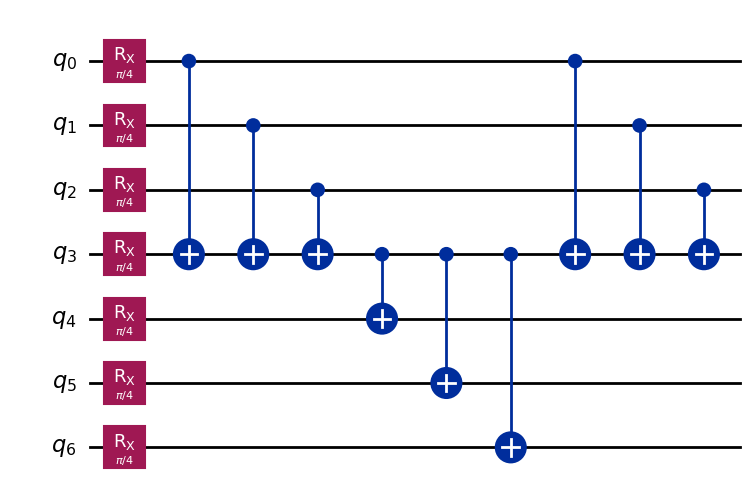

In [15]:
# Using circuit cuttng here
# using qiskit circuit-cutting gate, wire here
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
 
from qiskit_addon_cutting.instructions import Move, CutWire
from qiskit_addon_cutting import (
    partition_problem,
    generate_cutting_experiments,
    cut_wires,
    expand_observables,
    reconstruct_expectation_values,
)
 
 
qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
 
# Define observable
# Trong trường hợp này, chuỗi "ZIIIIII", "IIIZIII", "IIIIIIZ" đại diện cho các toán tử Pauli trên các qubit trong hệ thống qubit 7 qubit:
# "ZIIIIII":
# Áp dụng toán tử Z trên qubit 0, và các qubit còn lại giữ nguyên (identity I).
# Z là toán tử Pauli cho phép bạn đo lường spin của qubit trong cơ chế lượng tử với giá trị -1 khi ở trạng thái |1⟩ và +1 khi ở trạng thái |0⟩.
# "IIIZIII":
# Áp dụng toán tử Z trên qubit 3, và các qubit còn lại giữ nguyên (identity I).
# Đây có thể đại diện cho một phép đo trên qubit 3.
# "IIIIIIZ":
# Áp dụng toán tử Z trên qubit 6, và các qubit còn lại giữ nguyên (identity I).
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

 
# Draw circuit
qc_0.draw("mpl")

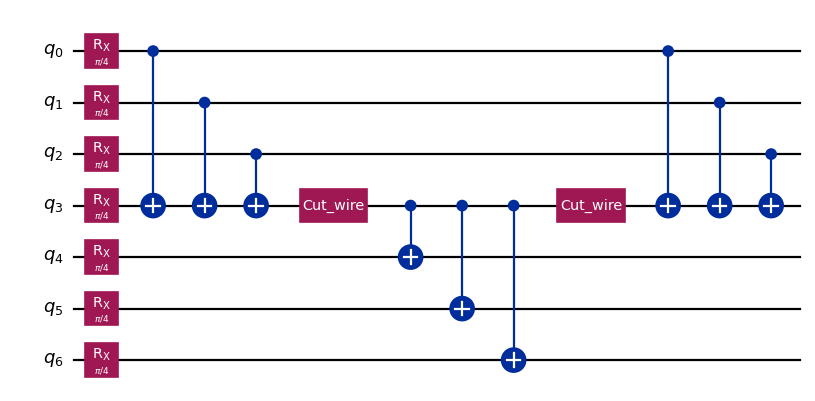

In [11]:
qc_1 = QuantumCircuit(7)
for i in range(7):
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(CutWire(), [3])
qc_1.cx(3, 4)
qc_1.cx(3, 5)
qc_1.cx(3, 6)
qc_1.append(CutWire(), [3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
 
qc_1.draw("mpl", scale=0.8)

Expanded Observable: ['ZIIIIIIII', 'IIIZIIIII', 'IIIIIIIIZ']


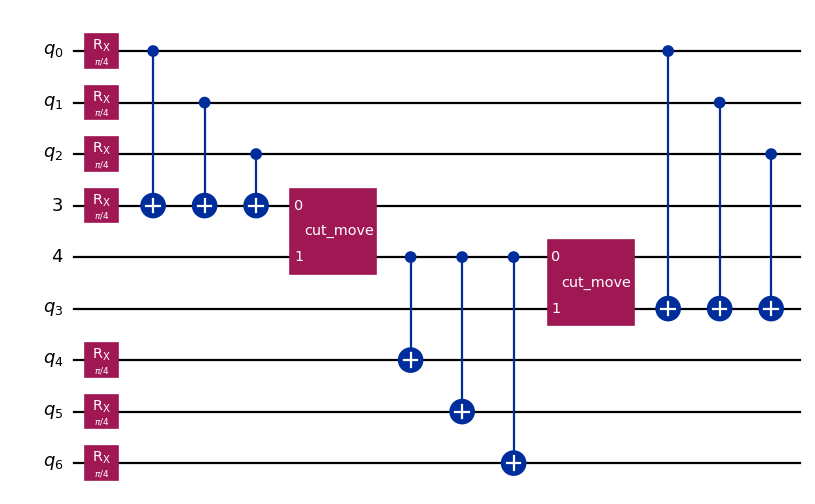

In [12]:
# Transform CutWire instructions to Move instructions
qc_2 = cut_wires(qc_1)
 
# Expand the observable to match the new circuit size
expanded_observable = expand_observables(observable.paulis, qc_0, qc_2)
print(f"Expanded Observable: {expanded_observable}")
qc_2.draw("mpl",0.8)

Subobservables to measure: 
{0: PauliList(['IIIII', 'ZIIII', 'IIIIZ']), 1: PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


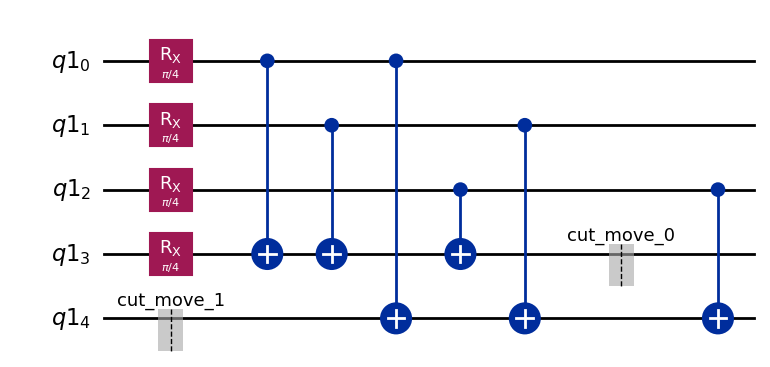

In [ ]:
partitioned_problem = partition_problem(
    circuit=qc_2,
    observables=expanded_observable,
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases
 
print(f"Subobservables to measure: \n{subobservables}\n")
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits[0].draw("mpl")

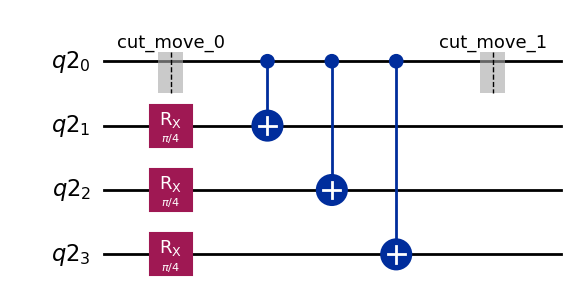

In [21]:
subcircuits[1].draw("mpl")

In [22]:
# Generate subexperiments
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
 
# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
 
# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
    # Retrieve results
    results = {label: job.result() for label, job in jobs.items()}

In [23]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
# Apply the coefficients of the original observable
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
 
# Compute the exact expectation value using the `qiskit_aer` package.
estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 1.3618176
Exact expectation value: 1.59099026
Error in estimation: -0.22917266
Relative error in estimation: -0.14404404


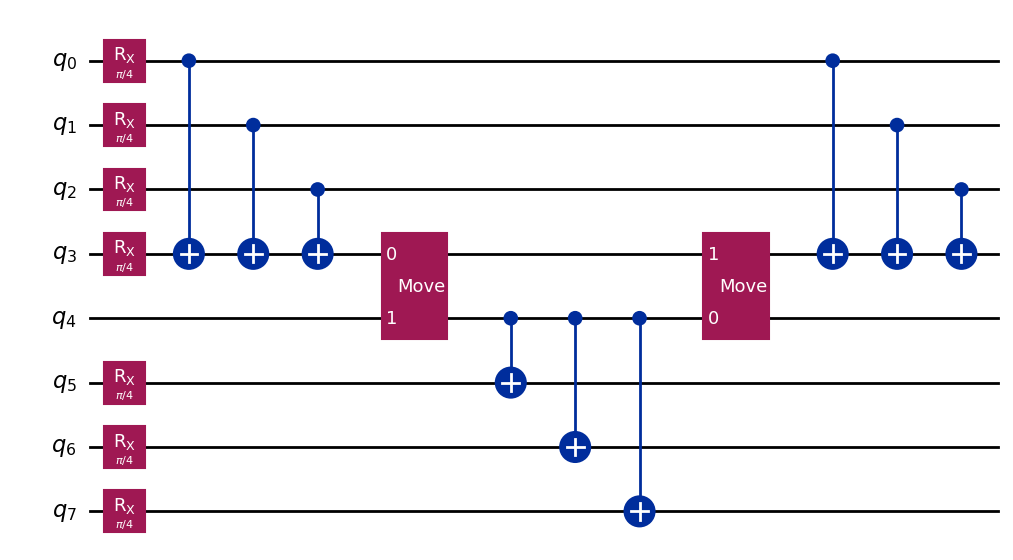

In [24]:
qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
 
# Expand observable
observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])
qc_1.draw("mpl")

Subobservables to measure: 
{'A': PauliList(['IIII', 'ZIII', 'IIIZ']), 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


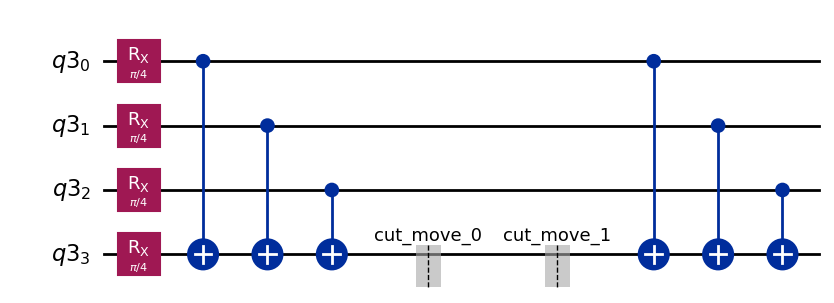

In [25]:
partitioned_problem = partition_problem(
    circuit=qc_1,
    partition_labels="AAAABBBB",
    observables=observable_expanded.paulis,
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases
 
print(f"Subobservables to measure: \n{subobservables}\n")
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits["A"].draw("mpl")

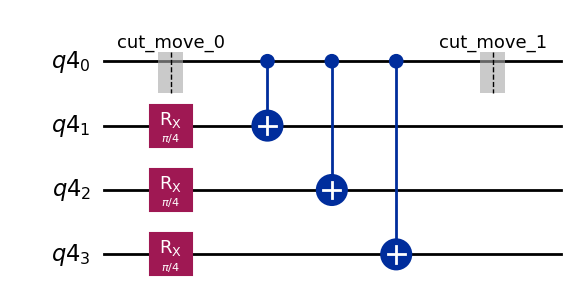

In [26]:
subcircuits["B"].draw("mpl")

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


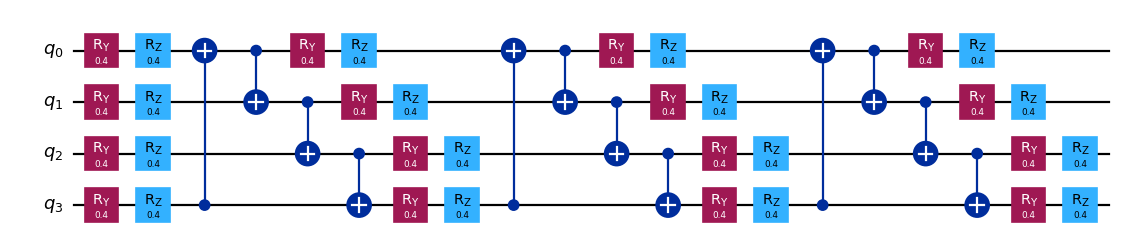

In [1]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2
from qiskit_addon_cutting import (
    cut_gates,
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)
 
circuit = efficient_su2(num_qubits=4, entanglement="circular")
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
 
 
observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
circuit.draw("mpl", scale=0.8)

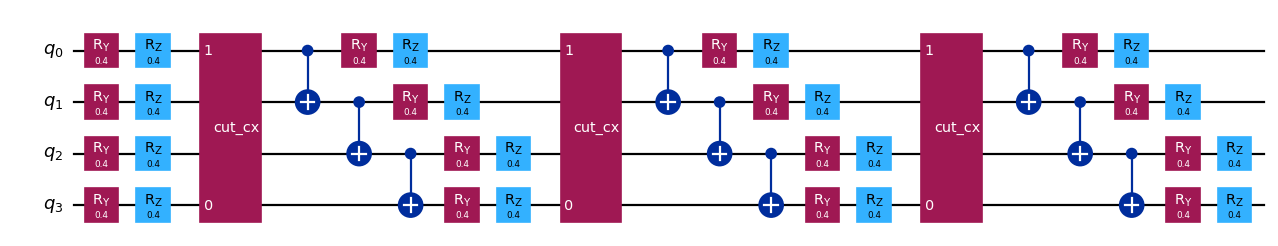

In [2]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]
 
# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)
 
qpd_circuit.draw("mpl", scale=0.8)

In [ ]:
# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)
 
# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = pass_manager.run(subexperiments)
 
# Set up the Qiskit Runtime Sampler primitive, submit the subexperiments, and retrieve the results
sampler = SamplerV2(backend)
job = sampler.run(isa_subexperiments, shots=4096 * 3)
results = job.result()
 
 
# Reconstruct the results
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
 
# Apply the coefficients of the original observable
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(circuit, observable, [0.4] * len(circuit.parameters))])
    .result()[0]
    .data.evs
)
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Observable: SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'XIXI', 'ZIZZ', 'IXIX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j])


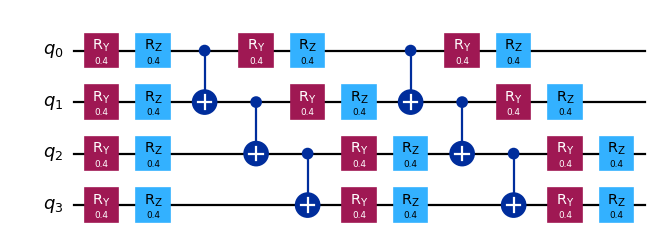

In [3]:
qc = efficient_su2(4, entanglement="linear", reps=2)
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)
 
 
observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])
print(f"Observable: {observable}")
 
qc.draw("mpl", scale=0.8)

Sampling overhead: 81.0
Subobservables: {'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']), 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}


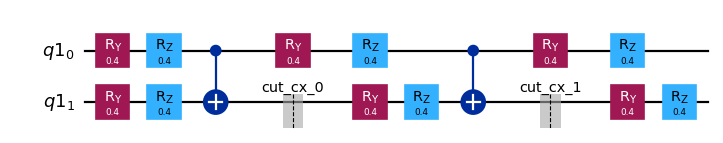

In [4]:
partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases
 
 
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
print(f"Subobservables: {subobservables}")
subcircuits["A"].draw("mpl", scale=0.8)

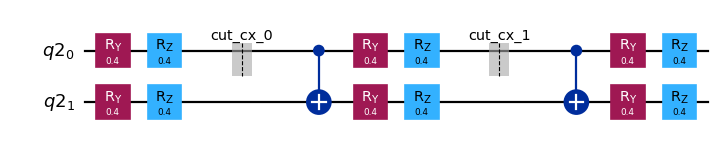

In [5]:
subcircuits["B"].draw("mpl", scale=0.8)

In [6]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
 
# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}
 
# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=1024 * 3)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }
 
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

In [ ]:
# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
 
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
 
 
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc, observable, [0.4] * len(qc.parameters))])
    .result()[0]
    .data.evs
)
from qiskit import QuantumCircuit
import numpy as np

# Tạo mạch với 1 qubit
qc = QuantumCircuit(1)

# Áp dụng cổng Hadamard để đưa qubit vào trạng thái superposition
qc.h(0)

# Áp dụng cổng R_z với pha θ = π
qc.rz(np.pi, 0)

# Đo qubit
qc.measure_all()

# Vẽ mạch
qc.draw('mpl')

print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.43177499
Exact expectation value: 0.56254612
Error in estimation: -0.13077114
Relative error in estimation: -0.23246296


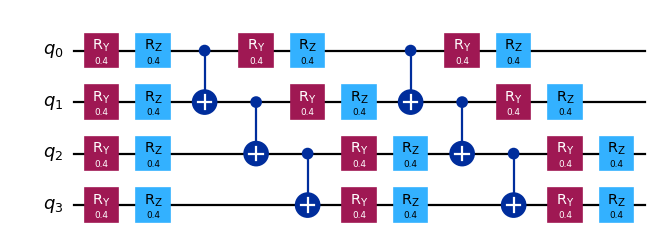

In [8]:
from qiskit.circuit.library import efficient_su2

qc = efficient_su2(4, entanglement="linear", reps=2)
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

qc.draw("mpl", scale=0.8)

In [9]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

In [10]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [12]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

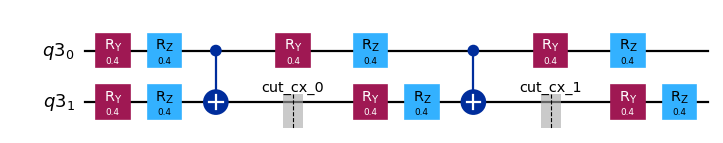

In [13]:
subcircuits["A"].draw("mpl", scale=0.8)

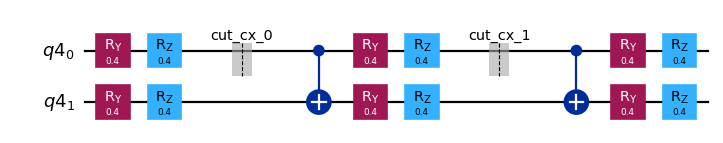

In [14]:
subcircuits["B"].draw("mpl", scale=0.8)

In [15]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


In [20]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

NameError: name 'subcircuits' is not defined

In [17]:
qcplus1 = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=3)
print(qcplus1)
qcplus1.draw("mpl")

NameError: name 'get_benchmark' is not defined

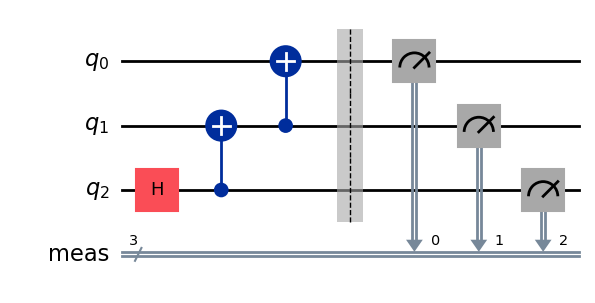

In [ ]:
qcplus2 = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=3)
qcplus2.draw("mpl")

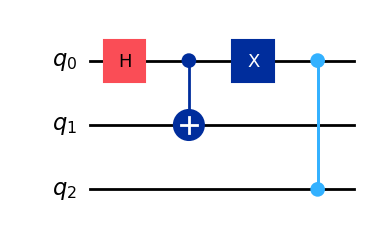

In [19]:
from qiskit import QuantumCircuit

# Giả sử qcplus1 và qcplus2 đều có 3 qubits và 0 clbits
qcplus1 = QuantumCircuit(3)
qcplus1.h(0)
qcplus1.cx(0, 1)

qcplus2 = QuantumCircuit(3)
qcplus2.x(0)
qcplus2.cz(0, 2)

# Tạo mạch mới với đủ qubits để chứa cả qcplus1 và qcplus2
qctotal = QuantumCircuit(6)  # 3 qubits cho qcplus1 và 3 qubits cho qcplus2

# Ghép qcplus1 và qcplus2
qctotal = qcplus1.compose(qcplus2, qubits=[0, 1, 2], clbits=[], inplace=False)

# In ra mạch kết quả
qctotal.draw('mpl')


# Apply scheduling to the benchmark circuits as require ment

In [ ]:
# Configuration
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}
# 3. Scheduling type

In [ ]:
# Setup
bigM = 1000000
timesteps = 2**5

from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation

In [ ]:
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/eba9885daf884917acb1026d3ff20799-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/eba9885daf884917acb1026d3ff20799-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 710 COLUMNS
At line 4649 RHS
At line 5355 BOUNDS
At line 5860 ENDATA
Problem MODEL has 705 rows, 514 columns and 2929 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.24521 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 493 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 394 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 176 strengthened rows, 

In [ ]:
#mapping the scheduling result to the machine
# check qiskit_102




In [ ]:
# assemble the circuit with calculation time in scheduling
# don't know



In [8]:
# reconstruct the result after cutting
# don't know




In [ ]:
# get the value

  job  qubits machine  capacity  start   end  duration
0   A       2   QUITO         5    0.0  14.0      14.0
1   B       3   QUITO         5    0.0   8.0       8.0
2   C       5   BELEM         5    0.0  20.0      20.0
3   D       2   QUITO         5    9.0  21.0      12.0


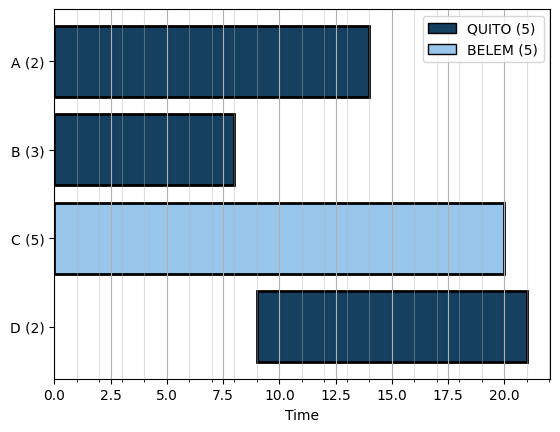

In [ ]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")


In [ ]:

# Analyze